In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba
from scipy.stats import norm
np.set_printoptions(threshold=np.inf)
from tqdm import tqdm
from itertools import chain
import random
from pendulum_dynamics import SimplePendulumDynamics, system_parameters
from numpy.random import Generator, MT19937, SeedSequence
rs = Generator(MT19937(SeedSequence(42)))
import sys

In [2]:
def traj_generate(M,N,epsilon=0.01):
  rs = Generator(MT19937(SeedSequence(0)))
  m, l, _ = system_parameters()
  A_0=1/l
  B_0=1/m/l/l

  for i in range(M):
    A = [A_0 + epsilon * np.random.rand()  for _ in range(M)]
    B = [B_0 + epsilon* np.random.rand() for _ in range(M)]
    # return A, B
  max_time_hor = 5    # maximum trajectory length

  # ------------------------------disturbacne-------------------------------------
  disturbance: str = "trunc_guass"
  parameter_dist = [0.0, 0.1, 10]  # mean and std

  # disturbance: str = "bernouli"

  # disturbance: str = "uniform"
  # parameter_dist = [-1, 1]  # lb and ub

  # ------------------------------Do not comment-------------------------------------

  mult_w = [1, 1]
  seeds_w = range(300, 10000) # fixing seeds
  w_max = 0.01             # maximum disturbance (required to run set membership)

  # ---------------------------------noise----------------------------------------
  c_input: str = "trunc_guass"
  parameter_input = [0.0, 1, 1]  # mean and std and scale

  # c_input: str = "bernouli"

  # c_input: str = "uniform"
  # parameter_input = [-1, 1]  # lb and ub

  mult_u = [1]
  seeds_u = range(100, 10000)   # fixing seeds


  # print('------------------Getting Trajectory Data of Pendulum-----------------')
  # theta_hat_list = []
  Delta_S_list = []
  Phi_S_U_list = []
  Phi_list = []
  State_list = []
  # print(A,B)
  for j in range(M):
    X=[]
    y=[]
    for e in range(N):
      x0 = [0.0 , 0.0]
      pend = SimplePendulumDynamics(c_input, disturbance)
      pend.get_trajectory_3(x0,A[j],B[j], max_time_hor, seeds_u[e], seeds_w[e], parameter_input, mult_u, parameter_dist, mult_w)
      # print("---------------------------------------------------------------------")
      # print("e = ", e + 1)
      # pend.plot_trajectory()

      # Delta_S_list.append(pend.b_s_list)
      # Phi_S_U_list.append(pend.phi_s_u_list)     # nonlinear feature vector

      # Phi_list.append(pend.phi_list)
      # State_list.append(pend.state_list)
      X.extend(pend.phi_s_u_list)
      y.extend(pend.b_s_list)

    Delta_S_list.append(y)
    Phi_S_U_list.append(X)    

      # Phi_list.extend(pend.phi_list)
      # State_list.extend(pend.state_list)

  return Phi_S_U_list,Delta_S_list,A,B

In [3]:
def improved_gradient_descent(x, y,params, batch_size, epochs,SGD=False, learning_rate=0.01, actual_params=None):
    # Normalize input data
    x_mean = np.mean(x, axis=0)
    x_std = np.std(x, axis=0) + 1e-8  
    x_normalized = (x - x_mean) / x_std
    n_samples=len(x)
    # n_samples, n_features = x_normalized.shape
    # params = np.zeros(2)
    errors = []
    mse_history = []
    # params=params*x_std
    # print(params)

    for epoch in range(epochs):
    
        indices = np.random.permutation(n_samples)
        x_shuffled = x_normalized[indices]
        y_shuffled = np.array(y)[indices]
        if SGD:
            # print('SGD execution')
            # sys.exit()
            for i in range(0, n_samples, batch_size):
                x_batch = x_shuffled[i:i+batch_size]
                y_batch = y_shuffled[i:i+batch_size]

                predictions = x_batch @ params
                gradient = (x_batch.T @ (predictions - y_batch)) / len(x_batch)

                current_lr = learning_rate / (1 + 0.01 * epoch)
                params -= current_lr * gradient
        else:
            
            predictions=x_shuffled @ params
            gradient = (x_shuffled.T @ (predictions - y_shuffled)) / len(x_shuffled)
            current_lr = learning_rate / (1 + 0.01 * epoch)
            params -= current_lr * gradient

        predictions = x_normalized @ params
        mse = np.mean((predictions - y) ** 2)
        mse_history.append(mse)
    final_params = params / x_std

    # return final_params, mse_history,x_std
    return params,final_params

In [4]:
def sys_id(M,N,epsilon,R,K,SGD):
    X,y,A,B=traj_generate(M,N,epsilon)
    # print(X[0])
    theta_c=np.zeros(2)
    theta_s=np.zeros(2)

    global_error=[]
    client_error=[]
    global_std=[]
    # print(SGD)
    for r in range(R):
        model=[]
        denorm_model=[]
        # client_error=[]

        # print('round',r)
        # theta_c_X=theta_s.copy()
        for i in range(M):
            # print(theta_c_X)
            # if i<3:
            #     print(theta_s)
            theta_c,theta_c_denorm = improved_gradient_descent(
                    X[i], y[i],theta_s, batch_size=10, epochs=K,SGD=SGD,
                    learning_rate=0.001)
            model.append(theta_c)
            denorm_model.append(theta_c_denorm)
            # global_std.append(x_std)
        theta_s=np.mean(model,axis=0)
        # print(theta_s)
        theta_c_X=theta_s.copy()
        # x_std_s=np.mean(global_std,axis=0)
        final_params = np.mean(denorm_model,axis=0)
        # final_params = theta_s 
        error=[]
        for i in range(M):
            error.append(np.linalg.norm(final_params -np.hstack([A[i],B[i]])) / np.linalg.norm(np.hstack([A[i],B[i]]))
                         )
            # error.append(np.linalg.norm(final_params -np.hstack([A[i],B[i]]),ord=2))
        # client_error.append(np.max(error))
        global_error.append(np.max(error))

        # global_error.append(np.linalg.norm(final_params -np.hstack([A[0],B[0]])) / np.linalg.norm(np.hstack([A[0],B[0]])))
    return final_params,global_error

In [7]:
q=5
R=50
K=1
SGD=False

# Varuing M

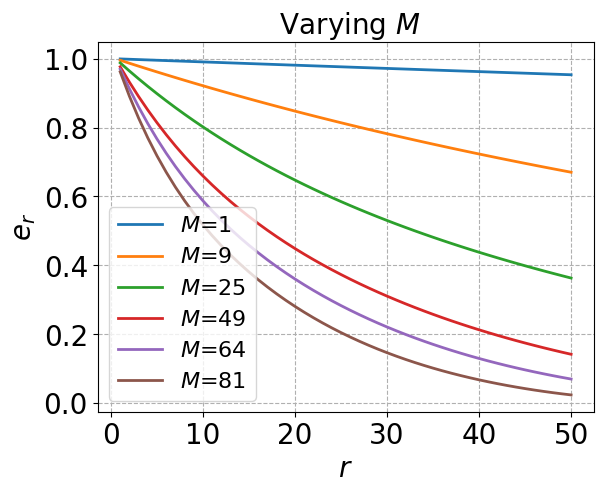

In [8]:
M=[1,9,25,49,64,81]

# eps=[0.01,0.1,0.2,2]
colors = ['#0072BD', '#D95319', '#EDB120', '#7E2F8E', '#77AC30']
# plt.subplot(1,3,1)
client_error_2=[]
for index,m in enumerate(M):
    seed_error=[]
    # print(M[index])
    for q_idx in range(q):
        theta_s,error=sys_id(m,10,0.01,R,K,SGD)
        seed_error.append(error)
    # print(len(seed_error))
    avg_error=np.mean(seed_error,axis=0)
    # print(len(avg_error))
    client_error_2.append(avg_error[-1])
    plt.plot(range(1, R+1), avg_error,label=f'$M$={M[index]}',linewidth=2)
    plt.xlabel(r'$r$',fontsize=20)
    plt.ylabel(r'$e_r$',fontsize=20)
    plt.xticks(fontsize=20)  # Increase x-axis tick font size
    plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
    plt.yticks(fontsize=20) 
    plt.title(' Varying $M$',fontsize=20)
    plt.grid(True, which='both', linestyle='--')
    plt.legend(fontsize=16)
plt.show()
# plt.savefig('Pendulum_sys_id_SGD_1_M.png',bbox_inches='tight')

# Varying N

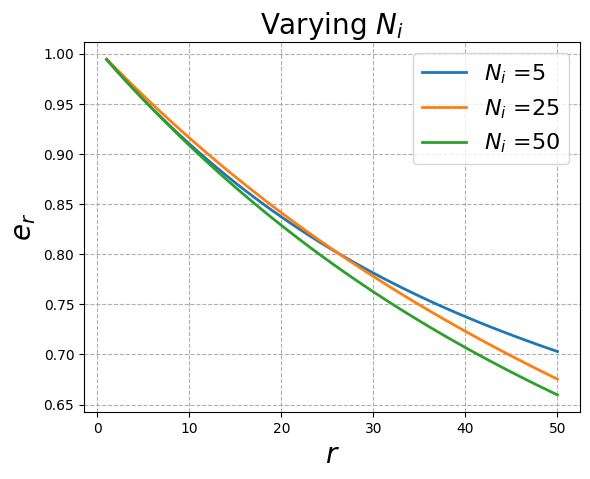

In [9]:
N=[5,25,50]
for index,n in enumerate(N):
    seed_error=[]
    for q_idx in range(q):
        theta_s,error=sys_id(10,n,0.1,R,K,SGD)
        seed_error.append(error)
    avg_error=np.mean(seed_error,axis=0)
    plt.plot(range(1, R+1), avg_error,label=f'$N_i$ ={N[index]}',linewidth=2)
    plt.xlabel(r'$r$',fontsize=20)
    plt.ylabel(r'$e_r$',fontsize=20)
    # plt.xticks(fontsize=20)  # Increase x-axis tick font size
    # plt.yticks(fontsize=20)
    # plt.yticks(np.linspace(0.2, 1.00, 5)) 
    plt.title(r'Varying $N_i$',fontsize=20)
    plt.grid(True, which='both', linestyle='--')
    plt.legend(fontsize=16)
plt.show()
# plt.savefig('Pendulum_sys_id_SGD.png')
# plt.savefig('Pendulum_sys_id_SGD_1_N.png',bbox_inches='tight')

# Varying epsilon

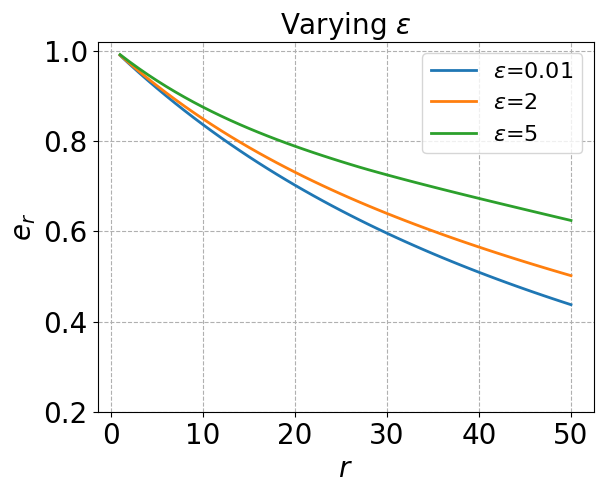

In [10]:
epsilon=[0.01,2,5]
for index,eps in enumerate(epsilon):
    seed_error=[]
    for q_idx in range(q):
        theta_s,error=sys_id(20,10,eps,R,K,SGD)
        seed_error.append(error)
    avg_error=np.mean(seed_error,axis=0)
    plt.plot(range(1, R+1), avg_error,label=f'$\epsilon$={epsilon[index]}',linewidth=2)
    plt.xlabel(r'$r$',fontsize=20)
    plt.ylabel(r'$e_r$',fontsize=20)
    plt.xticks(fontsize=20)  # Increase x-axis tick font size
    plt.yticks(fontsize=20)
    plt.yticks(np.linspace(0.20, 1.00, 5)) 
    plt.title(r'Varying $\epsilon$',fontsize=20)
    plt.grid(True, which='both', linestyle='--')
    plt.legend(fontsize=16)
plt.show()
# plt.savefig('Pendulum_sys_id_SGD_1_eps.png',bbox_inches='tight')